# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

/Users/viktordederer/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="lectures_batches", 
                                        batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model_artm = artm.ARTM(num_topics=T, 
                       topic_names=topic_names, 
                       class_ids={"text":1, "author":1},
                       num_document_passes=1, 
                       reuse_theta=True, 
                       cache_theta=True, 
                       seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"], 
                                                            topic_names = ['bcg']))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"], 
                                                            topic_names = topic_names[0:-1]))

Выполните еще 15 проходов по коллекции.

In [11]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
sbj1:  материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер
sbj2:  политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский
sbj3:  знание университет образование школа предмет восприятие познание факультет аргумент студент логика кафедра прикладной концепт гумбольдт
sbj4:  мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический синтаксис устный обезьяна детство словосочетание
sbj5:  бог миф греческий герой море мифология грек мифологический гусейнов персонаж шумерский гасан божество сущность генеалогия
sbj6:  русский город текст городской перевод корпус гласный документ говор москва пьеса горожанин немецкий древнерусский метро
sbj7:  трудность раса праздни

In [13]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_authors"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Сергей_Майоров Павел_Пахлов Игорь_Волобуев Валерий_Рубаков Сергей_Троицкий Лев_Дудко Эдуард_Боос Лев_Беклемишев Анатолий_Лиходед Роман_Мизюк Сергей_Кетов Аркадий_Цейтлин
sbj1:  Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Валентин_Крапошин Евгений_Гудилин Дмитрий_Гольберг Владимир_Пудалов Иван_Сорокин Наталья_Берлофф Пётр_Образцов Вадим_Бражкин Сергей_Морозов Владимир_Комлев Алексей_Кавокин
sbj2:  Алексей_Юдин Михаил_Бойцов Дина_Гусейнова Андрей_Лукашов Иван_Ладынин Татьяна_Смоктунович Зоригто_Намсараев Владимир_Малахов Кирилл_Мартынов Руслан_Хестанов Ольга_Тогоева Фёдор_Успенский Юрий_Рогулёв Владимир_Кузнецов Александр_Филиппов
sbj3:  Виктор_Вахштайн Наталья_Ростиславлева Татьяна_Клячко Григорий_Крейдлин Максим_Демин Дмитрий_Балалыкин Сергей_Зенкин Алексей_Котов Татьяна_Котова Илья_Иткин Александр_Пиперски Елена_Брызгалина Алексей_Руткевич Мария_Фаликман Борис_Миркин
sbj4:  Филипп_Хайтович Александр_Каплан Ольга_С

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = \
    [ u'Физика элементарных частиц'     # sbj0:  частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    , u'Материаловедение'               # sbj1:  материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер
    , u'История средних веков'          # sbj2:  политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский
    , u'Образование'                    # sbj3:  знание университет образование школа предмет восприятие познание факультет аргумент студент логика кафедра прикладной концепт гумбольдт
    , u'Изучение мозга'                 # sbj4:  мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический синтаксис устный обезьяна детство словосочетание
    , u'Мифология'                      # sbj5:  бог миф греческий герой море мифология грек мифологический гусейнов персонаж шумерский гасан божество сущность генеалогия
    , u'Русский язык'                   # sbj6:  русский город текст городской перевод корпус гласный документ говор москва пьеса горожанин немецкий древнерусский метро
    , u'Антропология'                   # sbj7:  трудность раса праздник шаман америка станислав африка тест нос монголоид дробышевский шаманский индеец сакральный задание
    , u'Римское право'                  # sbj8:  право римский правовой юрист суд юридический сон должник собственность обязательство закон владение собственник имущество исполнение
    , u'Медицина'                       # sbj9:  болезнь заболевание пациент лечение медицина врач боль препарат медицинский иммунный операция озеро сердце диагностика нарушение
    , u'Биология'                       # sbj10:  животное робот растение вода организм микроорганизм нервный рецептор биологический эволюция мембрана метан кислород мышца микроб
    , u'Память'                         # sbj11:  память информация когнитивный зрительный процесс запоминать психолог линзовидный воспроизводить картинка храниться мария кора хранение катастрофа
    , u'История первой мировой войны'   # sbj12:  империя германия историк церковь государственный русь святой военный российский великий князь немецкий война нация андрей
    , u'Социология'                     # sbj13:  наука социальный рассказывать общество понятие исторический кандидат история социология каков культурный сегодня научный сообщество современный
    , u'Астрофизика'                    # sbj14:  галактика планета земля звезда черный дыра масса газ атмосфера диск солнечный солнце космический расстояние скопление
    , u'Макроэкономика'                 # sbj15:  решение экономический экономика деньги компания принятие ценность международный выбор ресурс рынок экономист безопасность эффективность доверие
    , u'Психология'                     # sbj16:  человек поведение психология психологический эмоция конфликт мужчина коллективный эмоциональный способность женщина ощущение родитель психический идентичность
    , u'Информационные технологии'      # sbj17:  задача данные компьютер сеть программа компьютерный алгоритм интеллект интернет искусственный ошибка обучение вычислительный пользователь разработка
    , u'История Востока'                # sbj18:  территория словарь восток древний письменность народ китай северный памятник восточный китайский южный письмо население регион
    , u'Генетика'                       # sbj19:  клетка ген днк белок организм молекула генетический геном бактерия рнк мутация молекулярный ткань биологический вирус
    , u'Электромагнетизм'               # sbj20:  энергия квантовый поле магнитный атом электрон свет волна эффект фотон измерение оптический физико-математический ток частота
    , u'Философия'                      # sbj21:  культура философия философский философ автор женщина произведение платон роман писать религиозный идеология жанр мысль поэт
    , u'История французской революции'  # sbj22:  революция власть король французский реформа петр франция против сталин император народ крестьянин террор диктатура смерть
    , u'История России'                 # sbj23:  советский россия война мировой гражданский союз песня обряд екатерина самка ссср самец эмиграция большевик армия
    , u'Лингвистика'                    # sbj24:  язык христианский литературный литература лингвист христианство глагол филологический лингвистика языковой грамматика христианин арабский падеж английский
    , u'Теория относительности'         # sbj25:  теория пространство математический описывать уравнение матрица теоретический математика описание эйнштейн относительность линейный параметр механика геометрия
    , u'Театр'                          # sbj26:  внимание костюм коллективизация фразеологизм скелет сочетание банк термоэлектрический порнография финансовый фрейм воображение актер долг чувствительность
    , u'Астрономия'                     # sbj27:  звезда вселенная объект излучение белый нейтронный карлик спектр вещество телескоп измерять рентгеновский небо реликтовый сверхновый
    , u'Теория кино'                    # sbj28:  фильм роль свобода кино кинематограф культовый академия академический профессор бердяев отделение классика актер играть вечный
    ]
topic_labels = sbj_topic_labels + [u'Фоновая тема']

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])
phi_a.shape, theta.shape

((539, 30), (30, 1728))

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

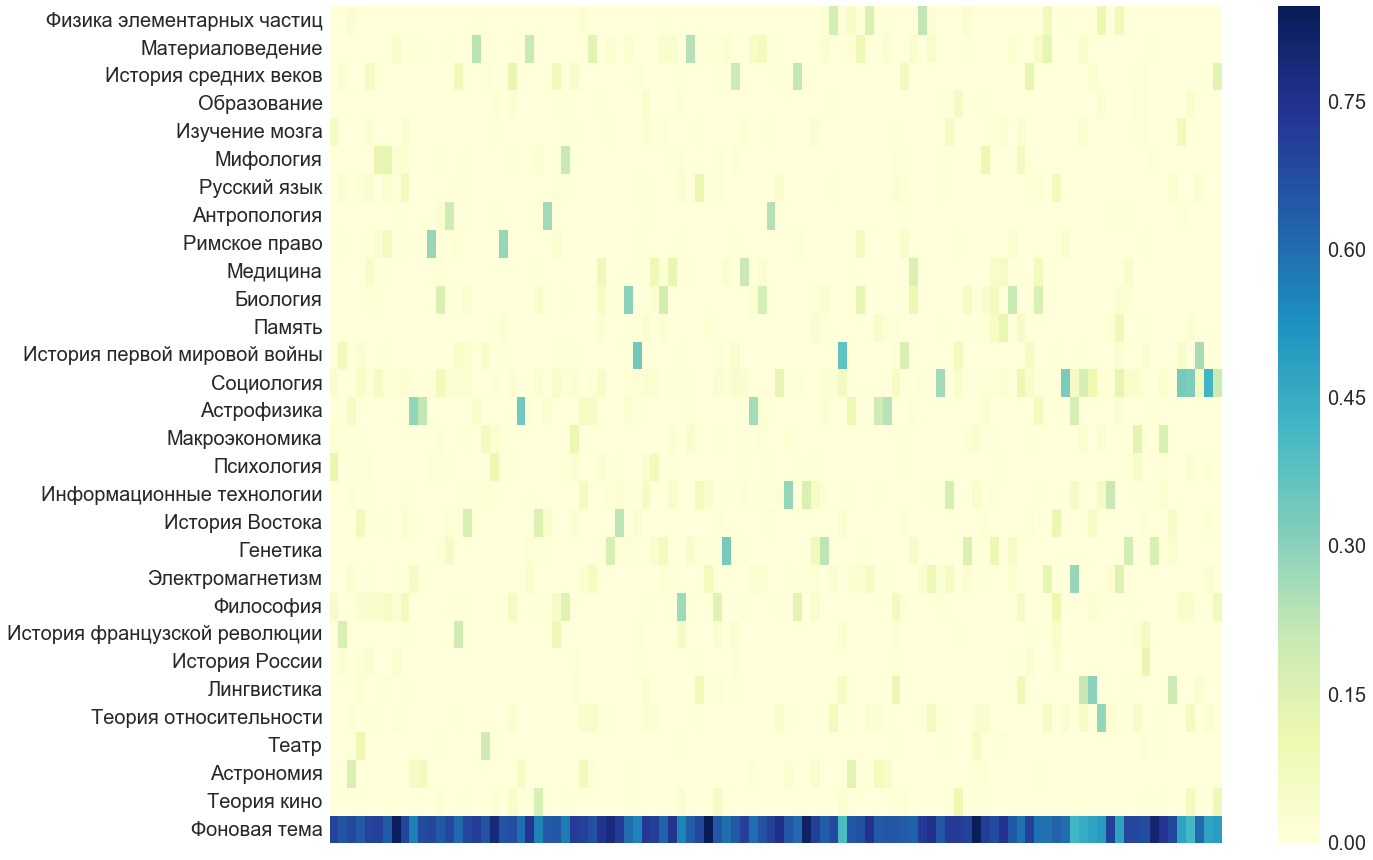

In [16]:
plt.figure(figsize=(20, 15))
seaborn.set(font_scale=2)
seaborn.heatmap(theta[theta.columns[0:100]], square=False, xticklabels=False, yticklabels=topic_labels, cmap="YlGnBu")
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [17]:
# Ваш код
pt = pd.DataFrame({'topic': topic_labels, 'p': theta.sum(axis=1)/theta.sum(axis=1).sum() })
pt

,p,topic
sbj0,0.009686,Физика элементарных частиц
sbj1,0.014894,Материаловедение
sbj2,0.009873,История средних веков
sbj3,0.006383,Образование
sbj4,0.006587,Изучение мозга
sbj5,0.006362,Мифология
sbj6,0.007620,Русский язык
sbj7,0.004716,Антропология
sbj8,0.008080,Римское право
sbj9,0.010677,Медицина


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [18]:
sorted_p = pt.sort_values(by='p', ascending=False)
sorted_p.head(6)

,p,topic
bcg,0.661268,Фоновая тема
sbj13,0.049602,Социология
sbj19,0.021600,Генетика
sbj20,0.016724,Электромагнетизм
sbj24,0.015168,Лингвистика
sbj10,0.015115,Биология


In [19]:
sorted_p.tail(3)

,p,topic
sbj11,0.005468,Память
sbj7,0.004716,Антропология
sbj26,0.003070,Театр


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

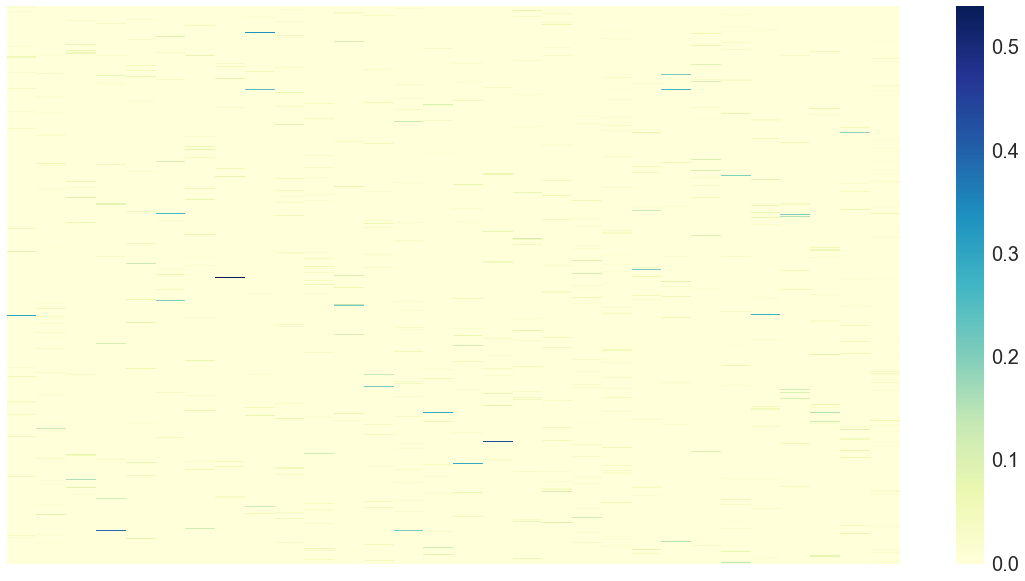

In [20]:
plt.figure(figsize=(20, 10))
seaborn.set(font_scale=2)
seaborn.heatmap(phi_a, square=False, xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [21]:
c = (phi_a>0.01).sum(axis=1)
c[c>=3]

Александр_Пиперски    4
Олег_Ауров            3
Ольга_Вайнштейн       3
Илья_Иткин            4
Андрей_Журавлев       3
Фёдор_Успенский       4
dtype: int64

Ваш ответ:
авторы, значимые в не менее чем 3 темах:
* Александр Пиперски
* Олег Ауров
* Ольга Вайнштейн
* Илья Иткин
* Андрей Журавлев
* Фёдор Успенский

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [22]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [23]:
n = phi_a * pt.p.T
d = n.sum(axis=1)
pta = n.divide(d, axis=0)

In [24]:
mds_model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
mds_transformed = mds_model.fit_transform(pairwise_distances(pta, metric='cosine'))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

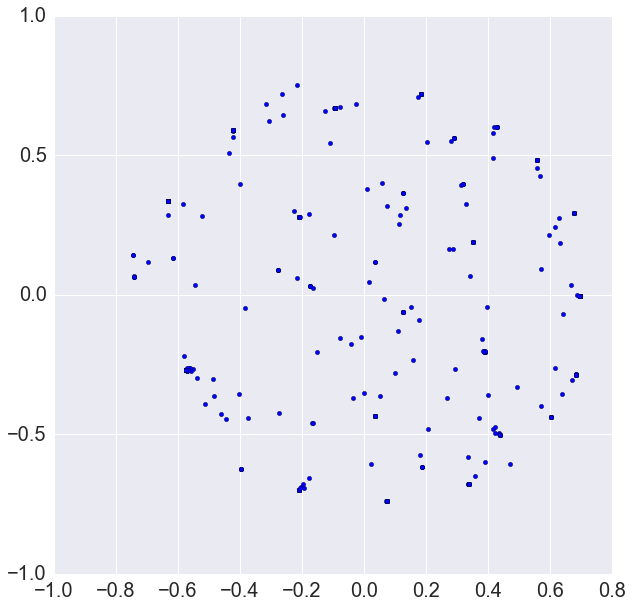

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(mds_transformed[:,0], mds_transformed[:,1])
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

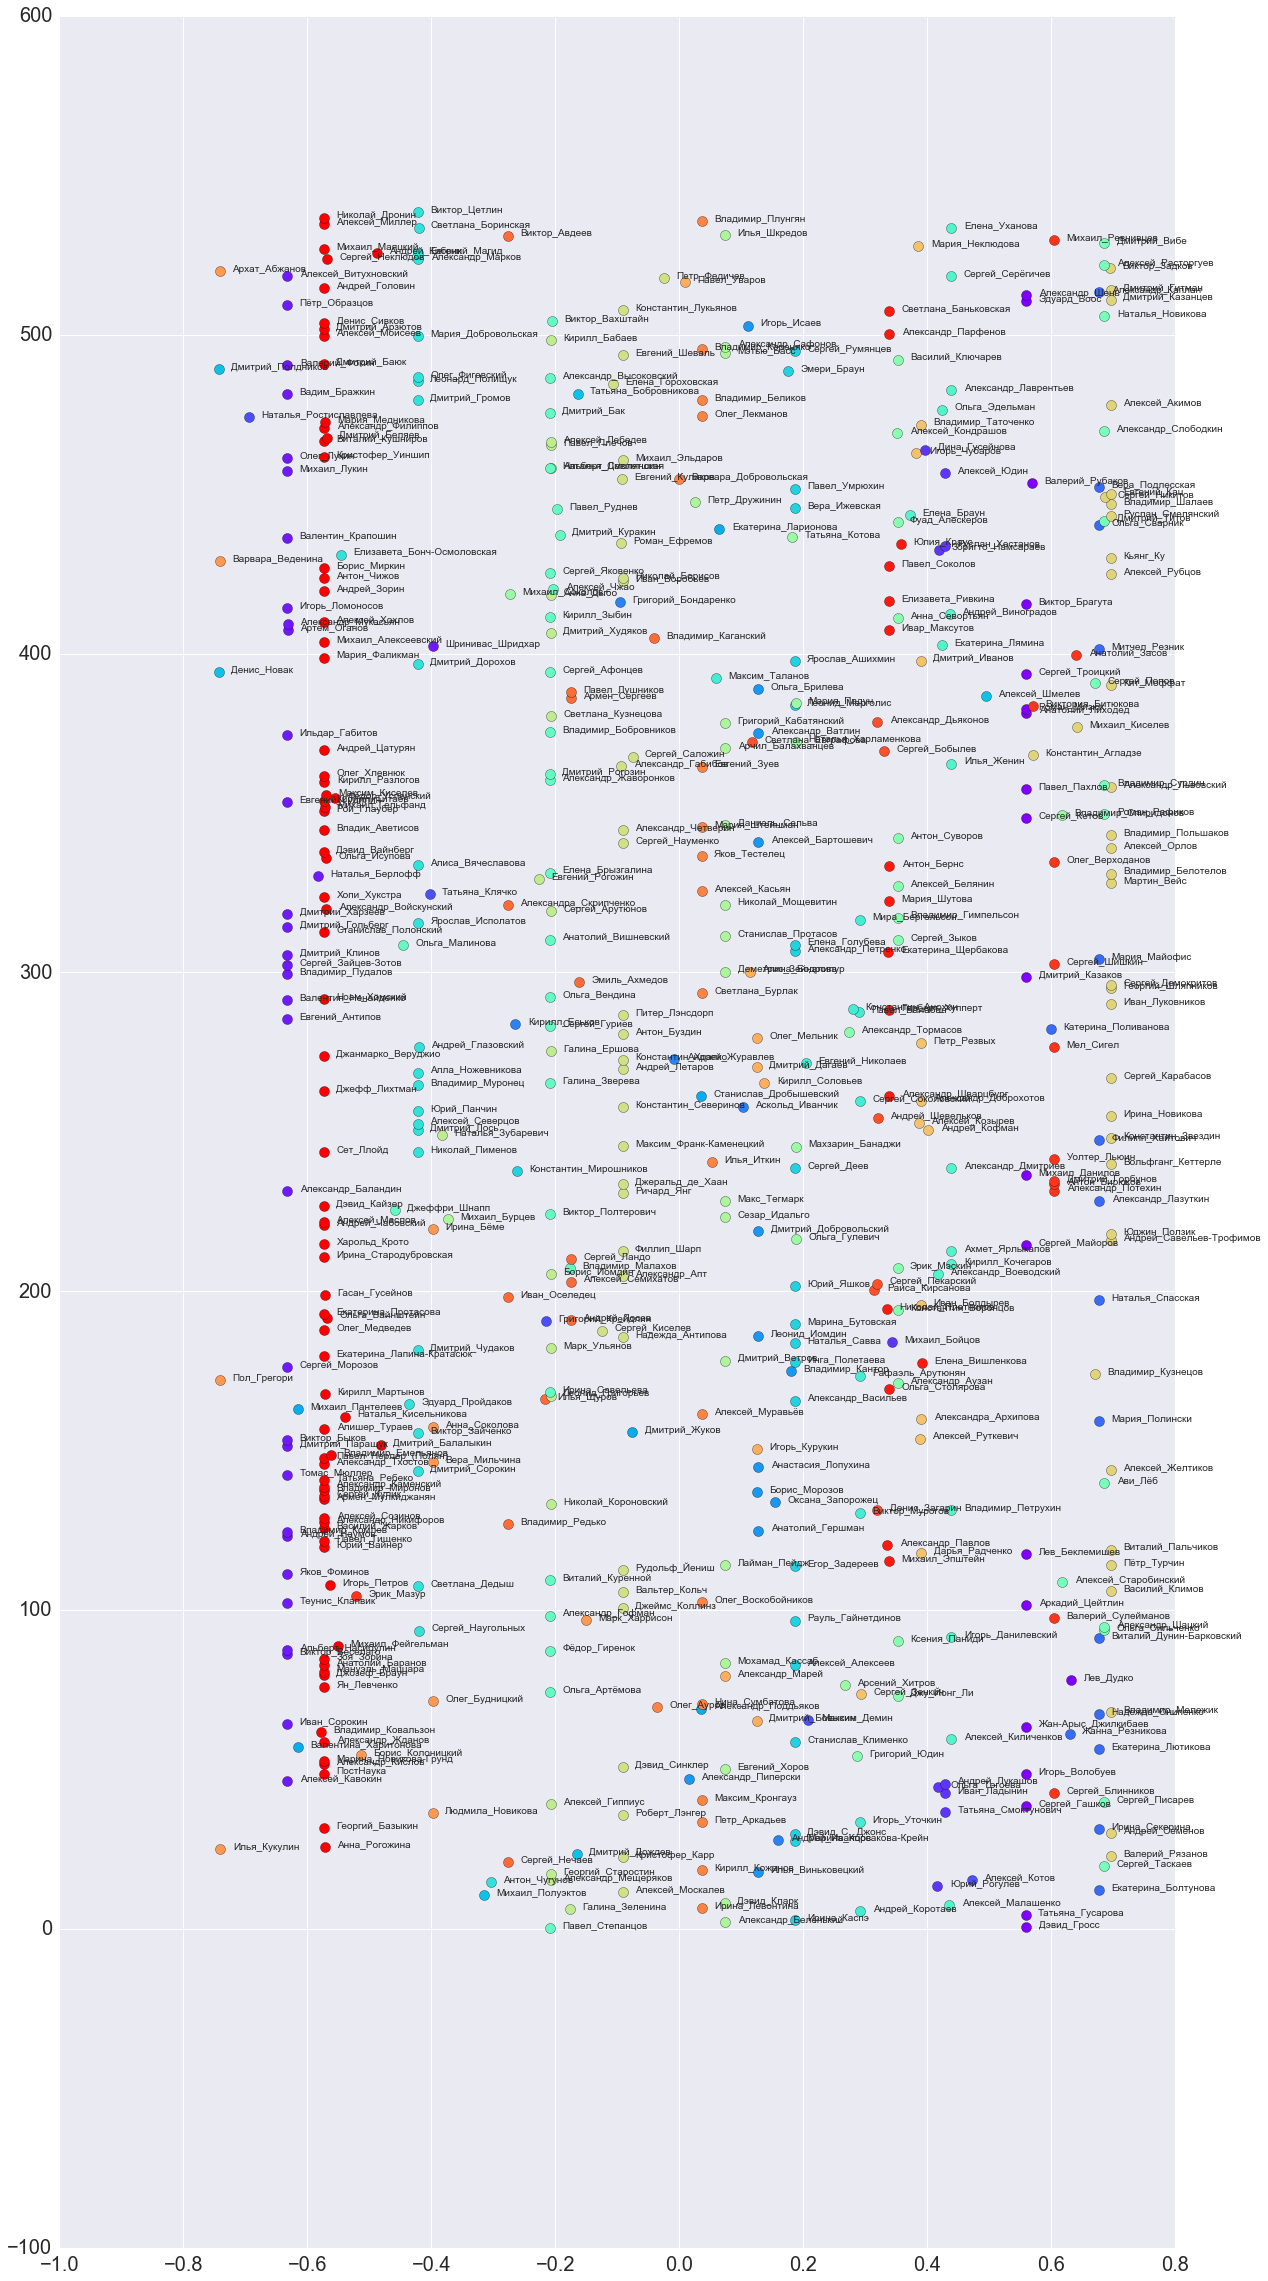

In [26]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

top_author_topics = pta.as_matrix().argmax(axis=1)

plt.figure(figsize=(20, 40))

for i, (x,y) in enumerate(mds_transformed):
    y = y + i
    topic_num = top_author_topics[i]
    author = pta.axes[0][i]
    plt.scatter(x, y, s=100, c=colors[topic_num])
    plt.annotate(author, xy=(x + 0.02, y), fontsize=10)

plt.savefig("authors.pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [27]:
n = theta
d = n.sum(axis=1)
pdt = n.divide(d, axis=0)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [28]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [29]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [42]:
def html(tmpl, val):
    display(HTML(tmpl.format(val)))
    
i = 0
for t, row in pdt.iterrows():
    html(u"<h2>{}</h2>", topic_labels[i])
    ts = model_artm.score_tracker['top_words'].last_tokens[t]
    html(u'<p>{}</p>', ', '.join(ts[0:10]))
    urls = row.sort_values(ascending=False).head(10)
    for url,v in urls.iteritems():
        print '{:.2f}% —'.format(v*100), url
    i = i + 1

2.27% — http://postnauka.ru/video/13043
2.09% — http://postnauka.ru/video/18870
1.90% — http://postnauka.ru/video/18873
1.70% — http://postnauka.ru/video/47950
1.66% — http://postnauka.ru/video/2945
1.61% — http://postnauka.ru/video/11634
1.56% — http://postnauka.ru/video/1894
1.56% — http://postnauka.ru/video/47175
1.55% — http://postnauka.ru/video/14282
1.55% — http://postnauka.ru/video/478


1.35% — http://postnauka.ru/video/31182
1.33% — http://postnauka.ru/video/13700
1.25% — http://postnauka.ru/video/57995
1.17% — http://postnauka.ru/video/18048
1.12% — http://postnauka.ru/video/41686
1.09% — http://postnauka.ru/video/13544
1.09% — http://postnauka.ru/video/51490
1.08% — http://postnauka.ru/video/50340
1.07% — http://postnauka.ru/video/46379
1.01% — http://postnauka.ru/video/56295


1.55% — http://postnauka.ru/video/5517
1.40% — http://postnauka.ru/video/5179
1.28% — http://postnauka.ru/video/32906
1.24% — http://postnauka.ru/video/13538
1.20% — http://postnauka.ru/video/52941
1.16% — http://postnauka.ru/video/32882
1.14% — http://postnauka.ru/video/56304
1.14% — http://postnauka.ru/video/12083
1.14% — http://postnauka.ru/video/59199
1.13% — http://postnauka.ru/video/53228


3.09% — http://postnauka.ru/video/2973
1.81% — http://postnauka.ru/video/31198
1.71% — http://postnauka.ru/video/19570
1.66% — http://postnauka.ru/video/35038
1.49% — http://postnauka.ru/video/55533
1.47% — http://postnauka.ru/video/49445
1.44% — http://postnauka.ru/video/40889
1.31% — http://postnauka.ru/video/55217
1.30% — http://postnauka.ru/video/50406
1.24% — http://postnauka.ru/video/3603


2.07% — http://postnauka.ru/video/50793
2.01% — http://postnauka.ru/video/55068
1.75% — http://postnauka.ru/video/12521
1.71% — http://postnauka.ru/video/47548
1.65% — http://postnauka.ru/video/26207
1.56% — http://postnauka.ru/video/5178
1.54% — http://postnauka.ru/video/25891
1.39% — http://postnauka.ru/video/27965
1.38% — http://postnauka.ru/video/36350
1.33% — http://postnauka.ru/video/7767


2.21% — http://postnauka.ru/video/43664
2.07% — http://postnauka.ru/video/5181
1.91% — http://postnauka.ru/video/27831
1.88% — http://postnauka.ru/video/42796
1.87% — http://postnauka.ru/video/31990
1.75% — http://postnauka.ru/video/21637
1.70% — http://postnauka.ru/video/46427
1.65% — http://postnauka.ru/video/12527
1.62% — http://postnauka.ru/video/36716
1.58% — http://postnauka.ru/video/47300


1.90% — http://postnauka.ru/video/13156
1.77% — http://postnauka.ru/video/51171
1.70% — http://postnauka.ru/video/8964
1.65% — http://postnauka.ru/video/24279
1.54% — http://postnauka.ru/video/48112
1.52% — http://postnauka.ru/video/24945
1.46% — http://postnauka.ru/video/47301
1.44% — http://postnauka.ru/video/57318
1.43% — http://postnauka.ru/video/23470
1.34% — http://postnauka.ru/video/10773


3.33% — http://postnauka.ru/video/31707
2.97% — http://postnauka.ru/video/37732
2.94% — http://postnauka.ru/video/32898
2.82% — http://postnauka.ru/video/35150
2.79% — http://postnauka.ru/video/42707
2.77% — http://postnauka.ru/video/15341
2.58% — http://postnauka.ru/video/42735
2.39% — http://postnauka.ru/video/17397
2.37% — http://postnauka.ru/video/31675
2.31% — http://postnauka.ru/video/40880


2.55% — http://postnauka.ru/video/9299
2.25% — http://postnauka.ru/video/38009
2.23% — http://postnauka.ru/video/34414
2.17% — http://postnauka.ru/video/49455
2.11% — http://postnauka.ru/video/17912
2.10% — http://postnauka.ru/video/16822
2.10% — http://postnauka.ru/video/42221
2.03% — http://postnauka.ru/video/31688
2.03% — http://postnauka.ru/video/31666
2.00% — http://postnauka.ru/video/17875


2.37% — http://postnauka.ru/video/13746
1.82% — http://postnauka.ru/video/532
1.80% — http://postnauka.ru/video/7753
1.73% — http://postnauka.ru/video/11361
1.69% — http://postnauka.ru/video/12974
1.60% — http://postnauka.ru/video/2541
1.58% — http://postnauka.ru/video/49206
1.56% — http://postnauka.ru/video/11850
1.52% — http://postnauka.ru/video/45961
1.47% — http://postnauka.ru/video/51384


1.32% — http://postnauka.ru/video/9861
1.28% — http://postnauka.ru/video/30673
1.23% — http://postnauka.ru/video/8953
1.17% — http://postnauka.ru/video/2531
1.15% — http://postnauka.ru/video/32635
1.14% — http://postnauka.ru/video/7113
1.11% — http://postnauka.ru/video/19071
1.07% — http://postnauka.ru/video/25889
0.97% — http://postnauka.ru/video/49437
0.92% — http://postnauka.ru/video/10786


3.15% — http://postnauka.ru/video/9997
2.43% — http://postnauka.ru/video/56052
2.23% — http://postnauka.ru/video/54916
2.04% — http://postnauka.ru/video/57336
1.57% — http://postnauka.ru/video/37979
1.50% — http://postnauka.ru/video/27845
1.43% — http://postnauka.ru/video/38507
1.38% — http://postnauka.ru/video/3645
1.33% — http://postnauka.ru/video/17421
1.32% — http://postnauka.ru/video/23079


1.54% — http://postnauka.ru/video/24034
1.45% — http://postnauka.ru/video/3348
1.38% — http://postnauka.ru/video/24039
1.32% — http://postnauka.ru/video/32637
1.28% — http://postnauka.ru/video/19574
1.17% — http://postnauka.ru/video/23900
1.14% — http://postnauka.ru/video/35041
1.14% — http://postnauka.ru/video/50668
1.10% — http://postnauka.ru/video/31183
1.09% — http://postnauka.ru/video/34936


0.66% — http://postnauka.ru/video/10783
0.62% — http://postnauka.ru/video/10749
0.62% — http://postnauka.ru/video/9148
0.55% — http://postnauka.ru/video/7778
0.53% — http://postnauka.ru/video/9870
0.50% — http://postnauka.ru/video/17491
0.50% — http://postnauka.ru/video/5878
0.50% — http://postnauka.ru/video/3417
0.49% — http://postnauka.ru/video/6380
0.49% — http://postnauka.ru/video/7541


1.67% — http://postnauka.ru/video/2971
1.58% — http://postnauka.ru/video/9835
1.39% — http://postnauka.ru/video/31193
1.33% — http://postnauka.ru/video/57338
1.31% — http://postnauka.ru/video/31695
1.25% — http://postnauka.ru/video/36249
1.21% — http://postnauka.ru/video/3604
1.18% — http://postnauka.ru/video/3423
1.16% — http://postnauka.ru/video/58744
1.15% — http://postnauka.ru/video/45644


1.86% — http://postnauka.ru/video/53415
1.72% — http://postnauka.ru/video/5465
1.66% — http://postnauka.ru/video/13152
1.50% — http://postnauka.ru/video/24286
1.43% — http://postnauka.ru/video/27823
1.38% — http://postnauka.ru/video/28278
1.37% — http://postnauka.ru/video/51488
1.33% — http://postnauka.ru/video/26119
1.31% — http://postnauka.ru/video/14280
1.28% — http://postnauka.ru/video/43679


1.72% — http://postnauka.ru/video/22892
1.28% — http://postnauka.ru/video/22883
1.25% — http://postnauka.ru/video/26223
1.24% — http://postnauka.ru/video/21643
1.14% — http://postnauka.ru/video/9865
1.09% — http://postnauka.ru/video/40866
1.00% — http://postnauka.ru/video/9729
0.93% — http://postnauka.ru/video/16191
0.93% — http://postnauka.ru/video/21661
0.89% — http://postnauka.ru/video/2946


1.74% — http://postnauka.ru/video/32901
1.71% — http://postnauka.ru/video/24306
1.56% — http://postnauka.ru/video/8313
1.27% — http://postnauka.ru/video/33885
1.23% — http://postnauka.ru/video/55303
1.22% — http://postnauka.ru/video/47810
1.17% — http://postnauka.ru/video/12172
1.11% — http://postnauka.ru/video/9998
1.09% — http://postnauka.ru/video/45717
1.07% — http://postnauka.ru/video/13155


1.89% — http://postnauka.ru/video/53171
1.46% — http://postnauka.ru/video/5891
1.28% — http://postnauka.ru/video/59201
1.26% — http://postnauka.ru/video/2527
1.18% — http://postnauka.ru/video/12515
1.14% — http://postnauka.ru/video/17041
1.14% — http://postnauka.ru/video/51380
1.13% — http://postnauka.ru/video/25290
1.07% — http://postnauka.ru/video/52958
1.06% — http://postnauka.ru/video/56302


1.25% — http://postnauka.ru/video/5390
0.99% — http://postnauka.ru/video/10475
0.93% — http://postnauka.ru/video/17051
0.92% — http://postnauka.ru/video/27434
0.88% — http://postnauka.ru/video/32881
0.88% — http://postnauka.ru/video/35461
0.87% — http://postnauka.ru/video/35051
0.86% — http://postnauka.ru/video/5915
0.86% — http://postnauka.ru/video/16156
0.84% — http://postnauka.ru/video/11628


1.30% — http://postnauka.ru/video/19457
1.21% — http://postnauka.ru/video/21662
1.21% — http://postnauka.ru/video/25875
1.21% — http://postnauka.ru/video/24434
1.05% — http://postnauka.ru/video/19509
1.04% — http://postnauka.ru/video/51174
0.98% — http://postnauka.ru/video/3381
0.95% — http://postnauka.ru/video/23335
0.95% — http://postnauka.ru/video/26609
0.94% — http://postnauka.ru/video/18221


1.45% — http://postnauka.ru/video/2529
1.37% — http://postnauka.ru/video/12738
1.24% — http://postnauka.ru/video/7764
1.18% — http://postnauka.ru/video/9728
1.15% — http://postnauka.ru/video/53513
1.10% — http://postnauka.ru/video/23834
1.07% — http://postnauka.ru/video/32664
1.00% — http://postnauka.ru/video/7068
0.99% — http://postnauka.ru/video/46317
0.98% — http://postnauka.ru/video/37965


2.10% — http://postnauka.ru/video/53577
1.85% — http://postnauka.ru/video/48492
1.71% — http://postnauka.ru/video/54175
1.69% — http://postnauka.ru/video/47823
1.62% — http://postnauka.ru/video/1893
1.59% — http://postnauka.ru/video/25882
1.54% — http://postnauka.ru/video/42993
1.52% — http://postnauka.ru/video/58542
1.47% — http://postnauka.ru/video/23161
1.47% — http://postnauka.ru/video/42996


2.24% — http://postnauka.ru/video/34413
2.19% — http://postnauka.ru/video/30261
2.03% — http://postnauka.ru/video/46939
1.91% — http://postnauka.ru/video/52936
1.74% — http://postnauka.ru/video/57259
1.69% — http://postnauka.ru/video/41680
1.66% — http://postnauka.ru/video/25890
1.64% — http://postnauka.ru/video/55219
1.60% — http://postnauka.ru/video/25906
1.60% — http://postnauka.ru/video/47816


1.57% — http://postnauka.ru/video/7755
1.45% — http://postnauka.ru/video/13041
1.22% — http://postnauka.ru/video/10473
1.18% — http://postnauka.ru/video/55301
1.17% — http://postnauka.ru/video/52778
1.14% — http://postnauka.ru/video/3387
1.12% — http://postnauka.ru/video/6720
1.09% — http://postnauka.ru/video/14297
1.05% — http://postnauka.ru/video/53169
1.03% — http://postnauka.ru/video/49203


1.75% — http://postnauka.ru/video/3388
1.43% — http://postnauka.ru/video/36804
1.42% — http://postnauka.ru/video/57128
1.36% — http://postnauka.ru/video/55069
1.28% — http://postnauka.ru/video/18085
1.28% — http://postnauka.ru/video/18086
1.23% — http://postnauka.ru/video/19456
1.15% — http://postnauka.ru/video/51371
1.15% — http://postnauka.ru/video/34416
1.14% — http://postnauka.ru/video/25278


4.39% — http://postnauka.ru/video/9389
3.68% — http://postnauka.ru/video/31684
3.54% — http://postnauka.ru/video/43843
3.27% — http://postnauka.ru/video/49866
3.12% — http://postnauka.ru/video/40004
2.87% — http://postnauka.ru/video/37978
2.82% — http://postnauka.ru/video/36242
2.70% — http://postnauka.ru/video/57127
2.59% — http://postnauka.ru/video/30601
2.39% — http://postnauka.ru/video/26616


2.95% — http://postnauka.ru/video/53693
2.49% — http://postnauka.ru/video/6673
2.11% — http://postnauka.ru/video/30015
1.67% — http://postnauka.ru/video/59202
1.59% — http://postnauka.ru/video/23969
1.57% — http://postnauka.ru/video/49447
1.54% — http://postnauka.ru/video/10756
1.49% — http://postnauka.ru/video/12372
1.45% — http://postnauka.ru/video/38007
1.44% — http://postnauka.ru/video/23500


3.01% — http://postnauka.ru/video/5396
2.43% — http://postnauka.ru/video/9429
2.40% — http://postnauka.ru/video/10779
2.32% — http://postnauka.ru/video/39723
2.28% — http://postnauka.ru/video/11246
2.04% — http://postnauka.ru/video/8623
1.73% — http://postnauka.ru/video/7074
1.66% — http://postnauka.ru/video/57126
1.61% — http://postnauka.ru/video/19436
1.49% — http://postnauka.ru/video/45548


0.08% — http://postnauka.ru/video/51365
0.08% — http://postnauka.ru/video/49851
0.08% — http://postnauka.ru/video/42436
0.08% — http://postnauka.ru/video/54112
0.08% — http://postnauka.ru/video/58752
0.08% — http://postnauka.ru/video/54668
0.07% — http://postnauka.ru/video/41678
0.07% — http://postnauka.ru/video/46943
0.07% — http://postnauka.ru/video/51494
0.07% — http://postnauka.ru/video/36857


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 